# This notebook compares two dimensionality reduction techniques: Autoencoders and principle-component-analysis
## ... using the iris dataset.

<br></br>
## | dimensionality reduction techniques:


### - In [autoencoder/](autoencoder/) I created an encoder-decoder model which has a bottleneck layer of two neurons. The 2d bottlenecks of all train samples are saved here: [autoencoder/iris_reduced.json](autoencoder/iris_reduced.json), autoencoder architecture:

<img src="notebook_images/architecture.png">

### - In [principal-component-analysis/](principal-component-analysis/) I used sklearns PCA function to create 2d projections of the dataset samples. The 2d projections of all train samples are saved here: [principal-component-analysis/iris_reduced.json](principal-component-analysis/iris_reduced.json)

## | load and visualize the autoencoder and PCA compressions:

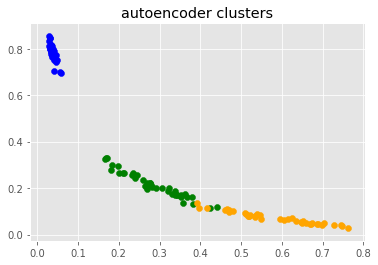

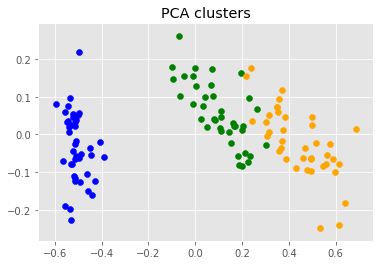

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json

# load 2d bottlenecks from train-set
with open("autoencoder/iris_train_reduced.json", "r") as f:
    ac_dataset = json.load(f)

# load 2d projections from train-set
with open("principal-component-analysis/iris_train_reduced.json", "r") as f:
    pca_dataset = json.load(f)


def get_clusters(dataset: list) -> list:
    """ split the dataset into three clusters, one for each class 
    
    :param list dataset: dataset with shuffled classes
    :return list: returns six lists (3 pairs for each class which each have a list with all the first elements 
     and one with all the second elements of the cluster, to make it matplotlib compatible)
    """

    cluster1x, cluster1y = [sample[0][0] for sample in dataset if sample[1] == [1, 0, 0]], [sample[0][1] for sample in dataset if sample[1] == [1, 0, 0]]
    cluster2x, cluster2y = [sample[0][0] for sample in dataset if sample[1] == [0, 1, 0]], [sample[0][1] for sample in dataset if sample[1] == [0, 1, 0]]
    cluster3x, cluster3y = [sample[0][0] for sample in dataset if sample[1] == [0, 0, 1]], [sample[0][1] for sample in dataset if sample[1] == [0, 0, 1]]
    return cluster1x, cluster1y, cluster2x, cluster2y, cluster3x, cluster3y


# clusters of the compressed train-set by the autoencoder and principal-component-analysis
ac_cluster1x, ac_cluster1y, ac_cluster2x, ac_cluster2y, ac_cluster3x, ac_cluster3y = get_clusters(ac_dataset)
pca_cluster1x, pca_cluster1y, pca_cluster2x, pca_cluster2y, pca_cluster3x, pca_cluster3y = get_clusters(pca_dataset)

# plot autencoder clusters
plt.scatter(ac_cluster1x, ac_cluster1y, c="blue")
plt.scatter(ac_cluster2x, ac_cluster2y, c="green")
plt.scatter(ac_cluster3x, ac_cluster3y, c="orange")

plt.title("autoencoder clusters")
plt.style.use("ggplot")
plt.show()

# plot PCA clusters
plt.scatter(pca_cluster1x, pca_cluster1y, c="blue")
plt.scatter(pca_cluster2x, pca_cluster2y, c="green")
plt.scatter(pca_cluster3x, pca_cluster3y, c="orange")

plt.title("PCA clusters")
plt.style.use("ggplot")
plt.show()

## | calculate accuracies for both approaches using k-nearest-neighbors:
### - step 1: create knn function using sklearn:

In [57]:
from sklearn.neighbors import NearestNeighbors

def knn(train_dataset: list, test_sample: list, K: int=5) -> list:
    """ gets the K nearest neighbors of a test-sample

    :param list train_dataset: samples of the train-dataset (without targets)
    :param list test_sample: one sample of the test-dataset (without target)
    :param int K: amount of nearest neighbors
    :return list: list with the indices of the K nearest neighbors
    """

    classifier = NearestNeighbors(n_neighbors=K)
    classifier.fit(train_dataset)
    nearest_neighbors = classifier.kneighbors([test_sample], return_distance=False)

    return nearest_neighbors

def get_prediction(train_targets: list, knn_indices: list) -> int:
    """ creates prediction from the knn-indices by checking which class' target occurs the most in the neighbors

    :param list train_targets: labels of the train-dataset (without samples)
    :param list knn_indices: list with the indices of the K nearest neighbors
    :return list: return index of the 1 in the one-hot encoded targets which represents the predicted class
    """

    classes = [0, 0, 0]
    for idx in knn_indices[0]:
        target = train_targets[idx].index(1)
        classes[target] += 1
    
    return classes.index(max(classes))

def get_knn_accuracy(train_dataset: list=[], test_dataset: list=[], K: int=5, plot_: bool=True) -> float:
    """ calculates the accuracy of knn on the test-set

    :param list train_dataset: train-dataset (samples and targets)
    :param list test_dataset: test-dataset (samples and targets)
    :param int K: amount of nearest neighbors
    :param bool plot_: if set to 'True', the predictions will be plotted
    :return float: accuracy
    """

    if plot_:
        # plot train clusters
        cluster1x, cluster1y, cluster2x, cluster2y, cluster3x, cluster3y = get_clusters(train_dataset)
        plt.scatter(cluster1x, cluster1y, c="blue", alpha=0.35)
        plt.scatter(cluster2x, cluster2y, c="green", alpha=0.35)
        plt.scatter(cluster3x, cluster3y, c="orange", alpha=0.35)

    # split targets from samples
    train_samples, train_targets = [sample[0] for sample in train_dataset], [sample[1] for sample in train_dataset]
    test_samples, test_targets = [sample[0] for sample in test_dataset], [sample[1] for sample in test_dataset]

    correct = 0
    for i in range(len(test_samples)):
        test_sample, test_target = test_samples[i], test_targets[i]
        nearest_neighbors_indices = knn(train_samples, test_sample, K=K)

        class_index = get_prediction(train_targets, nearest_neighbors_indices)
        predicted_target = [0, 0, 0]
        predicted_target[class_index] = 1

        if plot_:
            if predicted_target == [1, 0, 0]: color = "blue"
            elif predicted_target == [0, 1, 0]: color = "green"
            elif predicted_target == [0, 0, 1]: color = "orange"
            plt.scatter(test_sample[0], test_sample[1], c=color, edgecolors="black", s=50)

        if predicted_target == test_target:
            correct += 1
    
    if plot_:
        plt.style.use("ggplot")
        plt.show()
    
    return (correct / len(test_samples))



### - step 2: calculate the accuracies:

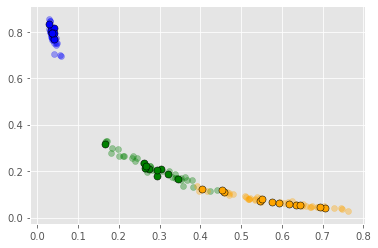

96.55172%


In [68]:
# rename autoencoder-dataset for clarity
ac_train_set = ac_dataset

# load 2d bottlenecks from test-set
with open("autoencoder/iris_test_reduced.json", "r") as f:
    ac_test_set = json.load(f)

ac_accuracy = get_knn_accuracy(train_dataset=ac_train_set, test_dataset=ac_test_set, K=5, plot_=True)
print(str(round(100 * ac_accuracy, 5)) + "%")


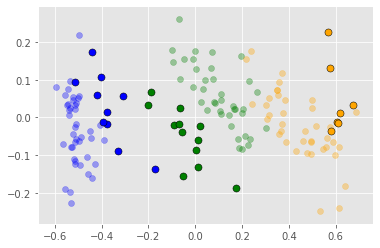

37.93103%


In [69]:
# rename pca-dataset for clarity
pca_train_set = pca_dataset

# load 2d projections from test-set
with open("principal-component-analysis/iris_test_reduced.json", "r") as f:
    pca_test_set = json.load(f)

pca_accuracy = get_knn_accuracy(train_dataset=pca_train_set, test_dataset=pca_test_set, K=5, plot_=True)
print(str(round(100 * pca_accuracy, 5)) + "%")

### - step 3: find optimal K with the elbow method:

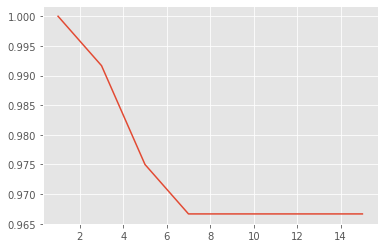

In [67]:
Ks = [1, 3, 5, 7, 9, 11, 13, 15]
ac_accuracies = [get_knn_accuracy(train_dataset=ac_train_set, test_dataset=ac_train_set, K=k, plot_=False) for k in Ks]
plt.plot(Ks, ac_accuracies)
plt.show()